# 1. Bilder für Identification vorbereiten

In diesem Notebook werden Schritt für Schritt die notwendigen Operationen durchgeführt, um die Bilder für das Trainieren eines Klassifikators vorzubereiten. Eingangs muss der Pfad für die eingehenden Bilder richtig gesetzt werden. 

In [28]:
import os
import torch
import numpy as np

from PIL import Image, ImageOps
from torchvision import transforms as tr

from matplotlib import pyplot as plt
import matplotlib.patches as patches

# Konstanten
IMG_WIDTH	= 300
IMG_HEIGHT	= 300

# NOTE: Dieser Pfad muss auf den ordner full_sorted zeigen
INPUT_IMGS_PATH  = 'C:/dev/netcase/cow_dataset/full_sorted/'

PAD_IMGS_PATH    = 'data/pad_resize/'
BOX_IMGS_PATH    = 'data/bounding_box/'
AUG_IMG_PATH     = 'data/augment/'

# Funktion zum ausgeben eines Bildes mit Bounding Box
def display_bbox(inputs, best_results_per_input, classes_to_labels):
    fig, ax = plt.subplots(1)
    # Show original, denormalized image...
    image_idx = 0
    image = inputs[image_idx] / 2 + 0.5
    ax.imshow(image)
    # ...with detections
    bboxes, classes, confidences = best_results_per_input[image_idx]
    for idx in range(len(bboxes)):
        left, bot, right, top = bboxes[idx]
        x, y, w, h = [val * 300 for val in [left, bot, right - left, top - bot]]
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, "{} {:.0f}%".format(classes_to_labels[classes[idx] - 1], confidences[idx]*100), bbox=dict(facecolor='white', alpha=0.5))

def print_predictions(best_results_per_input, classes_to_labels):
    # Abzählen aller Bilder
    total_images = len(best_results_per_input)
    
    no_occ   = 0
    one_occ  = 0
    two_occ  = 0

    for image_idx in range(len(best_results_per_input)):
        bboxes, classes, confidences = best_results_per_input[image_idx]
        
        count = np.count_nonzero(classes == 20)
        if count == 0:
            no_occ += 1
        elif count == 1:
            one_occ += 1
        elif count == 2:
            two_occ += 1


    return total_images, no_occ, one_occ, two_occ

## 1.1. Bilder padden und resizen
Damit die Bilder für das bestimmen der Bounding-Boxes verwendet werden können, müssen sie zunächt auf die richtige Größe gebracht werden. Um die Seitenverhältnisse nicht zu verzerren, werden die Originalbilder links und rechts mit einem Padding versehen und dann auf die richtig Größe (300x300 Pixel) angepasst. 

Weiterhin ist wichtig, dass die Ordnerstruktur berücksichtigt wird. Die Unterordner im data-Verzeichnis enthalten immer jeweils Bilder eine individuellen Kuh.

In [2]:
# Output Ordner erstellen, falls er nicht existiert
if not os.path.isdir(PAD_IMGS_PATH):
    os.mkdir(PAD_IMGS_PATH)

for img_dir in os.listdir(INPUT_IMGS_PATH):
    if os.path.isdir(os.path.join(INPUT_IMGS_PATH, img_dir)):
        for img_file in os.listdir(os.path.join(INPUT_IMGS_PATH, img_dir)):
            
            input_path = os.path.join(INPUT_IMGS_PATH, img_dir, img_file)
            
            # Ordner und Nicht-Bild Dateien überspringen
            if not os.path.isdir(input_path) and os.path.splitext(input_path)[-1].lower() == ".jpg":
            
                # Vorbereiten der Bilder
                image = Image.open(input_path)
                image = ImageOps.pad(image, (IMG_WIDTH, IMG_HEIGHT))
                image = image.rotate(90)
                
                # Ausgabeordner für jeweilige Kuh anlegen
                output_dir = os.path.join(PAD_IMGS_PATH, img_dir)
                if not os.path.isdir(output_dir):
                    os.mkdir(output_dir)
                
                # Bild speichern
                output_path = os.path.join(PAD_IMGS_PATH, img_dir, img_file)
                image.save(output_path)

                image.close()

## 1.2. Bounding-Boxes bestimmen und extrahieren
[Hou et al.](https://www.mdpi.com/2078-2489/12/9/361/htm) nutzen in ihrer Implementation des Systems einen Single Shot Multibox Detector (SSD). Diesen selbst aufzusetzen und zu trainieren ist für diese Beipiel allerdings nicht zielführend. NVIDIA bietet hier einen [Out-Of-The-Box Lösung](https://docs.nvidia.com/deeplearning/dali/user-guide/docs/examples/use_cases/pytorch/single_stage_detector/pytorch_ssd.html), die wir anwenden, um die Bounding-Boxes zu bestimmen. Da der Detector am COCO Dataset trainiert wurde, kann er Kühe bereits erkennen und benötigt dementsprechend keine weiteren Anpassungen mehr.

Der folgende Code ist stark an die [Pytorch Anleitung](https://pytorch.org/hub/nvidia_deeplearningexamples_ssd/) angelehnt und unterscheidet sich hauptsächlich darin, dass die generierten Bounding-Boxes genutzt werden, um die Bildausschnitte zu extrahieren.

Using cache found in C:\Users\Christian/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub
Using cache found in C:\Users\Christian/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub


Anzahl von Bildern Gesamt: 236
Anzahl Bilder ohne erkannte Kühe: 0
Anzahl Bilder eine erkannte Kuh: 226
Anzahl Bilder zwei erkannte Kühe: 10


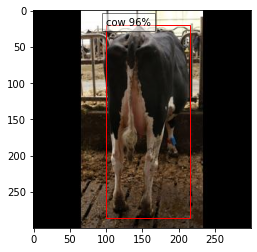

In [29]:
# create output directory if it does not exist
if not os.path.isdir(BOX_IMGS_PATH):
    os.mkdir(BOX_IMGS_PATH)

# Laden des Models und zusätzlicher Utility 
ssd_model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd')
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd_processing_utils')

# Konfiguration des Models 
ssd_model.to('cuda')
ssd_model.eval()

show_one     = True
total_images = 0
no_occ       = 0
one_occ      = 0
two_occ      = 0

# Pro Kuh, alle Bounding Boxes in den Bildern bestimmen 
for img_dir in os.listdir(PAD_IMGS_PATH):
    # Liste aller Bild-Pfade
    uris = []

    # Alles Bild-Pfade im Ordner laden 
    for img_file in os.listdir(os.path.join(PAD_IMGS_PATH, img_dir)):
        uris.append(os.path.join(PAD_IMGS_PATH, img_dir, img_file))
    
    # Vorbereiten der Bilder (vgl. Tutorial)
    inputs = [utils.prepare_input(uri) for uri in uris]
    tensor = utils.prepare_tensor(inputs)

    with torch.no_grad():
        detections_batch = ssd_model(tensor)

    # Resultate verarbeiten (vgl. Tutorial) 
    results_per_input = utils.decode_results(detections_batch)
    best_results_per_input = [utils.pick_best(results, 0.40) for results in results_per_input]
    classes_to_labels = utils.get_coco_object_dictionary()

    # Auswertung
    images, no, one, two = print_predictions(best_results_per_input, classes_to_labels)
    total_images += images
    no_occ       += no
    one_occ      += one
    two_occ      += two

    if show_one:
        display_bbox(inputs, best_results_per_input, classes_to_labels)
        show_one = False

    for image_idx in range(len(best_results_per_input)):
        # Originales, wiederhergestelltes Bild
        image = inputs[image_idx] / 2 + 0.5
        bboxes, classes, confidences = best_results_per_input[image_idx]

        # Bestes Match
        max_index = confidences.argmax()
        
        # Bounding Box extrahieren
        # NOTE: Im Vergleich zum Tutorial mussten top und bot getauscht werden, da y=0 normalerweise unten ist.
        left, top, right, bot = bboxes[max_index] * 300

        # NOTE: Die Pixelwerte in image sind floats und müssen erst in 8-Bit ints umgewandelt werden.
        output_image = Image.fromarray((image * 255).astype(np.uint8))
        output_image = output_image.crop((left, top, right, bot))

        # Zurückschreiben
        head, tail = os.path.split(img_dir)
        
        output_dir = os.path.join(BOX_IMGS_PATH, tail + '/')
        if not os.path.isdir(output_dir):
            os.mkdir(output_dir)

        output_path = os.path.join(BOX_IMGS_PATH, tail + '/', str(image_idx) + '.jpg')
        output_image.save(output_path)
        output_image.close()

    # NOTE: Die Implementation vom SSD scheint den GPU Speicher nicht eigentständig freizugeben. Dementsprechend wird er hier explizit geleert.
    torch.cuda.empty_cache()

print(f'Anzahl von Bildern Gesamt: {total_images}')
print(f'Anzahl Bilder ohne erkannte Kühe: {no_occ}')
print(f'Anzahl Bilder eine erkannte Kuh: {one_occ}')
print(f'Anzahl Bilder zwei erkannte Kühe: {two_occ}')

## 1.3. Image Dataset Augmentation
Um ausreichendes Bildmaterial zur Verfügung zu haben und Probleme wie Overfitting zu vermeiden, werden nun auf den Datensatz einfache geometrische Transformationen angewendet. Dies ist eine gängige Methode beim Trainieren von Neuronalen Netzen und wurde auch in [Hou et al.](https://www.mdpi.com/2078-2489/12/9/361/htm) durchgeführt. Hier wurde der Datensatz um das 20-fache vergrößert.

In diesem Beispiel wird der Datensatz auf das 8-fache vergrößert.

In [3]:
# Anzahl der Kopien pro Bild
AUGMENT_FACTOR = 8

# Erstellen des Verzeichnises, falls es nicht existiert
if not os.path.isdir(AUG_IMG_PATH):
    os.mkdir(AUG_IMG_PATH)

# Pipeline, um Bilder zu flippen und/oder verzerren 
applier = tr.RandomApply(transforms=[tr.RandomHorizontalFlip(), 
                                     tr.RandomPerspective(distortion_scale=0.6, p=1), 
                                     tr.RandomResizedCrop(size=(224, 224), scale=(0.7, 1.0))], p=1)

for img_dir in os.listdir(BOX_IMGS_PATH):
    img_index = 0
    for img_file in os.listdir(os.path.join(BOX_IMGS_PATH, img_dir)):
        to_augment = Image.open(os.path.join(BOX_IMGS_PATH, img_dir, img_file))

        # Originales Bild speichern
        if not os.path.isdir(os.path.join(AUG_IMG_PATH, img_dir)):
            os.mkdir(os.path.join(AUG_IMG_PATH, img_dir))

        to_augment.save(os.path.join(AUG_IMG_PATH, img_dir, img_file))

        # Augmentation anwenden
        augmented_imgs = [applier(to_augment) for _ in range(AUGMENT_FACTOR)] 
        
        # Augmented Bilder speichern
        for aug_index in range(len(augmented_imgs)):
            img_path = os.path.join(AUG_IMG_PATH, img_dir, 'aug_' + str(img_index) + '_' + str(aug_index) + '.jpg')
            augmented_imgs[aug_index].save(img_path)

        img_index += 1
        to_augment.close()